## 1. Introduction

### (1)Background information

### Project Outline
For this project, we are conducting our own data analysis, using data from a project conducted by UBC Computer Science researchers in The Pacific Laboratory for Artificial Intelligence (PLAI) Group. These researchers are studying how people play video games by recording play sessions on a specific MineCraft server and collecting relevant data. Our goal is to formulate a predictive question from our exploration of the datasets "players.csv" and "sessions.csv" and answer it using reading, wrangling, visualization, and classification skills that we have learnt so far in DSCI 100.

### PLAICraft
The datasets supplied to us for this project come from the PLAI group's MineCraft research server, PLAICraft. PLAICraft player data includes skill level, subscription status, demographic, and individual play session data.

### (2)Question we tried to answer
#### **Broad Question**
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### **Specific Question**
Can experience, age and played hours predict whether a player subscribes to a game-related newsletter in the PLAICraft server dataset?

### (3)Describe the dataset
#### Game player data set
This data was taken from [a research group in Computer Science at UBC](https://plai.cs.ubc.ca/). This dataset contains information about players and their game sessions collected from the PLAICraft research game server. The goal is to analyze the factors that influence players' likelihood of subscribing to the game newsletter.

**players.csv**: This data is a list of all unique players, including data about each player. According to the website, the file contains the following information:

* experience (character) = The player's experience level.
* subscribe (logical) = Subscription to the game newsletter (TRUE / FALSE)
* hashedEmail (character) = Player's Hashed email
* played_hours (numeric) = Total play time (hours)
* name (character) = Player's name
* gender (character) = Player's gender
* Age (numeric) = Player's age
  
**sessions.csv**: A list of individual play sessions by each player, including data about the session. According to the website, the file contains the following information:

* hashedEmail (character) = Player's Hashed email
* start_time (character) = Session start time (Format: DD/MM/YYYY HH:MM)
* end_time (character) = Session end time (Format: DD/MM/YYYY HH:MM)
* original_start_time (numeric) = Unix timestamp of session start
* original_end_time (numeric) = Unix timestamp of session end

## 2. Methods & Results

### (1) K-Nearest Neighbors (KNN) Classification. 
We are using KNN classification to predict whether a new player entering the game will subscribe to the PLAICraft newsletter based on their input for the chosen variables (experience, Age, played_hours). 

This method of classification calculates the distance between a new data point and its K-nearest neighbors and assigns the majority class as the prediction result. The steps are as follows:
* Load in R packages and datasets
* Clean the dataset:
    * Convert `subscribe` into a factor variable
    * Convert `experience` into numeric variables
    * Handle missing values
    * Standardize the `played_hours` and `Age` data
    * Remove players whose `played_hours` is 0, as they do not contribute meaningful game behaviour data
    * Drop hashedEmail and name as they’re not relevant for prediction
* Visualize the clean data and explore the relationship between each variable with subscription status
* Split the data into training and testing by 70/30
* Build training model
* Use cross-validation on training data to find the best K for our classification model
* Retrain model with chosen K
* Calculate accuracy of model
* Predict a new player's class label (subscribed? true or false) using our model


### (2) Execution

In [1]:
# Load necessary R packages
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Read csv files
players_url <- "https://raw.githubusercontent.com/Harry672-ai/group_project_individual/refs/heads/main/players.csv"
sessions_url<- "https://raw.githubusercontent.com/Harry672-ai/group_project_individual/refs/heads/main/sessions.csv"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:

#Cleaning Dataset

#Convert subscribe to factor
players <- players |>
    mutate(subscribe = as.factor(subscribe))

#Convert experience to numeric
players <- players|>
    mutate(experience = recode(experience,
                             "Beginner" = 0,
                             "Amateur" = 1,
                             "Regular" = 2,
                             "Pro" = 3,
                             "Veteran" = 4))|>
mutate(experience = as.numeric(experience))

#Handle missing values in age
players <- players |>
    drop_na()|>
#Remove players with played_hours == 0
    filter(played_hours > 0)|>
#select the variable we want
    select(experience, subscribe, played_hours, Age)

players

#data summary

#The number of people who subscribed
people_subscribe <- players|>
filter(subscribe == 'TRUE')|>
nrow()

#The number of people who didn't subscribed
people_not_subscribe <- players|>
filter(subscribe == 'FALSE')|>
nrow()

people_subscribe
people_not_subscribe

experience,subscribe,played_hours,Age
<dbl>,<fct>,<dbl>,<dbl>
3,TRUE,30.3,9
4,TRUE,3.8,17
1,TRUE,0.7,21
⋮,⋮,⋮,⋮
4,TRUE,0.1,44
4,FALSE,0.3,22
1,FALSE,2.3,17


[1] 84

[1] 25

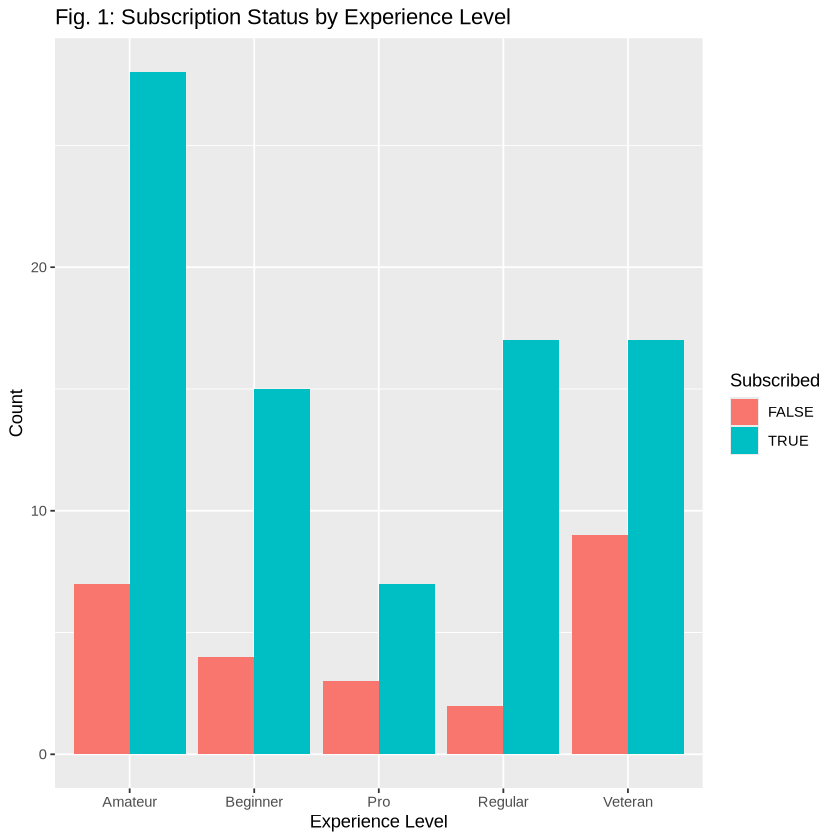

In [4]:
#We can now explore the relationships between each predictor and subscription status

#Visualization 1: Bar plot of subscription status by experience level
#Converting numeric experience variable back to character for vizualization

players_experience_characters <- players|>
    mutate(experience = recode(experience,
                             `0` = "Beginner",
                             `1` = "Amateur",
                             `2` = "Regular",
                             `3` = "Pro",
                             `4` = "Veteran"))|>
    mutate(experience = as.character(experience))

plot_experience<-players_experience_characters |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge") +  # Side-by-side bar plot for subscription counts
    labs(title = "Fig. 1: Subscription Status by Experience Level",
        x = "Experience Level",
        y = "Count",
        fill = "Subscribed")

plot_experience

Figure 1 shows the relationship between experience and subscription status. According to figure 1, there are the most amateur players and least pro players. All levels of experience have a majority of the players subscribed to the newsletter. This might be because players are interested in learning about the game through the newsletter. Non-subscribers might still be interested in the game, but might not necessarily feel like they must subscribe to the newsletter. 

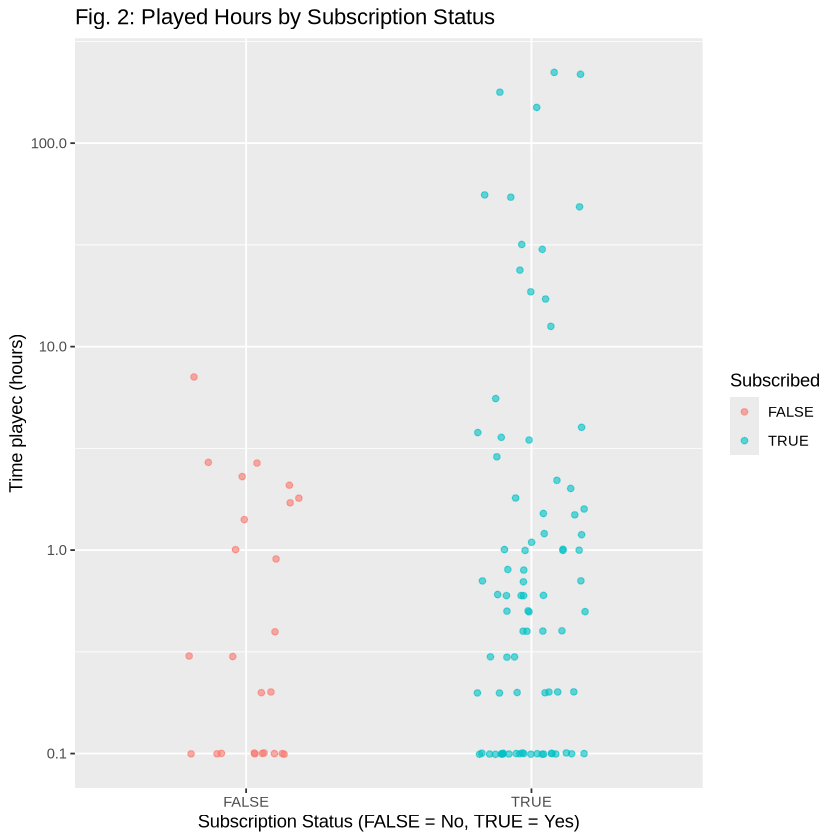

In [5]:
#Visualization 2: Jitter plot of subscription status by played hours

plot_hours <- players |>
    ggplot(aes(x = subscribe, y = played_hours, color = subscribe)) +
    geom_jitter(width = 0.2, alpha = 0.6) +
    labs(title = "Fig. 2: Played Hours by Subscription Status",
        x = "Subscription Status (FALSE = No, TRUE = Yes)",
        y = "Time playec (hours)",
        color = "Subscribed") +
    scale_y_log10(labels =label_comma())

plot_hours

Figure 2 shows the relationship between number of hours played on PLAICraft and subscription status. Subscription numbers increase as time played increases. According to the jitter plot in Fig. 2, it shows that the subscribed players play more hours than non-subscribers. Players that are subscribed are subscribed because they might want to know about ways to engage in the game to maximize the fun.

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


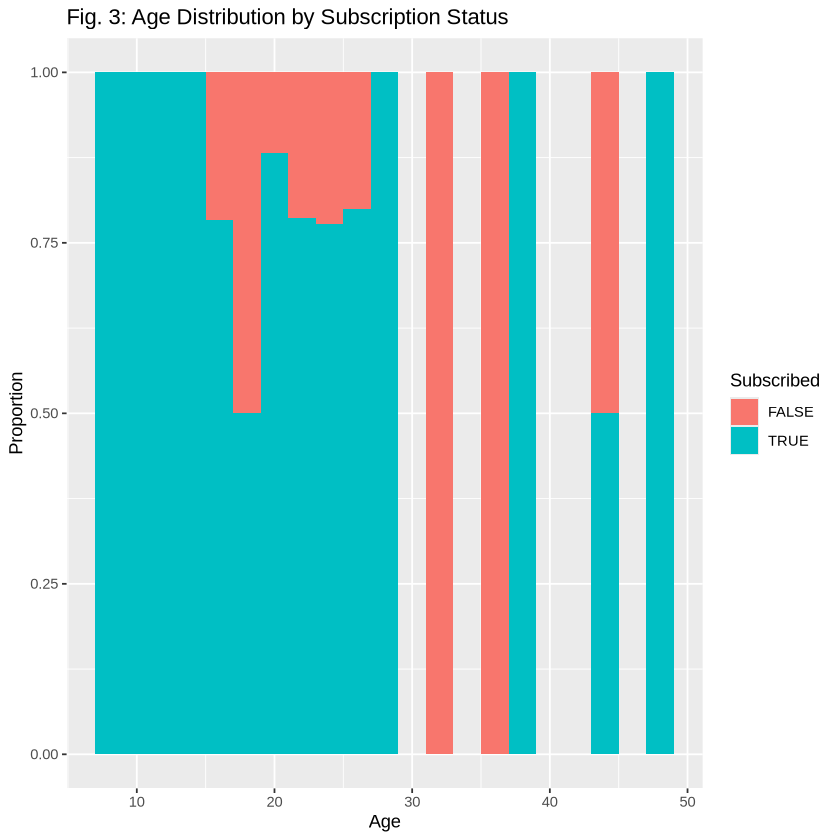

In [6]:
#Visualization 3: histogram of subscription status by Age
plot_age <-ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 2, position = "fill") +
  labs(
    title = "Fig. 3: Age Distribution by Subscription Status",
    x = "Age",
    y = "Proportion",
    fill = "Subscribed") 
plot_age

Figure 3 shows the proportion of newsletter subscribers for all player ages. Younger players (<15 years old) have the highest proportion of subscribers. There isn't enough data to fully understand the subscription patterns based on age since a lot of ages have zero data entries and the total number of players is low, meaning one player could significantly impact the trend in subscription by age.

In [7]:
set.seed(2026)
#Performs the data analysis
players_split <- initial_split(players, prop = 0.7, strata = subscribe)

players_train <- training(players_split)

players_test <- testing(players_split)

#Create the recipe
recipe <- recipe(subscribe~., data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Create the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [8]:
#Make the tibble of Value of K that we want to try
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

In [9]:
set.seed(2026)
#Split the data
vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

#Fit the knn model
fit <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec) |>
    tune_grid(resample = vfold, grid = k_vals)

#Collect the metrics
metrics <- collect_metrics(fit)

#Finding the best K
best_k <- metrics |>
        filter(.metric == "accuracy") |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

[1] 13

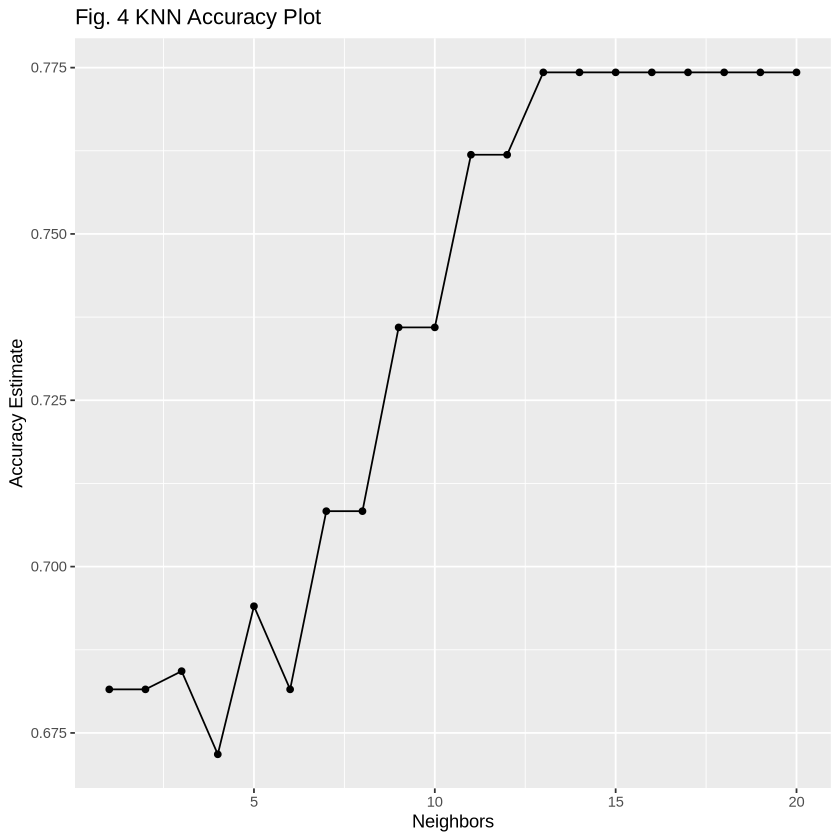

In [10]:
set.seed(2026)
#Plot the accuracy versus K to choose the best K
#Visualization 4 shows the accuracy plot of K, so that we can choose the best K
cross_val_plot <- metrics |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle( "Fig. 4 KNN Accuracy Plot")
cross_val_plot

Figure 4 shows the model accuracy for K values 1-20. The K with the highest accuracy is K = 13. 

In [11]:
#Create the model for the best K
knn_spec_best_K <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
    set_engine("kknn") |>
    set_mode("classification")

#Fit the knn model for the best K
fit_best_K <- workflow() |>
    add_recipe(recipe) |>
    add_model(knn_spec_best_K) |>
    fit(data = players_train)

#Predict the testing data
players_predictions <- predict(fit_best_K, players_test)

#Merge the prediction with testing data to compare the prediction
players_predictions <- bind_cols(players_predictions, players_test)
players_predictions

.pred_class,experience,subscribe,played_hours,Age
<fct>,<dbl>,<fct>,<dbl>,<dbl>
TRUE,4,TRUE,3.8,17
TRUE,0,TRUE,1.5,25
TRUE,1,TRUE,0.5,17
⋮,⋮,⋮,⋮,⋮
TRUE,1,TRUE,32.0,22
TRUE,3,FALSE,1.7,17
TRUE,4,TRUE,0.1,44


In [12]:
#Collect the metrics
players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7352941


In [13]:
#Make the confusion matrix
players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE      8   25

## Summary
We consider the people who subscribed  as our positive predictions. Based on the confusion matrix we created, the precision is calculated as 26 / (26 + 7) = 26 / 33 ≈ 0.78, and the recall is 26 / (26 + 0) = 26 / 26 = 1. The accuracy of the model is (26+1) / (26 + 1 + 7) = 27 / 34 ≈ 0.79. In that case, our model works pretty well, because our recall and precision and accuracy number is pretty high.

## **3. Discussion**

## What Was Expected Initially vs What Was Predicted
### Experience 
It was expected for the less experienced players to be subscribed because as you become more experienced in a game, there seems to be less reliance on newsletter and advertisements as their many years of experience allow them to have their own tips and tricks that come with their expertise. Also as mentioned earlier, amateurs are new to the game and do not have the same experience as the experienced players like the pros and veterans meaning that they do not have their own tips and tricks and will need to get the help of the games newsletter to learn more about events and tricks to level up and find ways to maximize the fun in the game playing.
### Age
For age, it was expected for the younger groups to have higher subscription rates because younger people generally have more free time than the older population as they are occupied with school and work. However from the data presented above, it made sense to see that older people can have higher rates of subscription as well because younger people have less freedom over their gaming time as it could be monitored by the parents, older people when they become adults have freedom over their time and so can have higher subscription rates as well because they are now able to invest their time into playing the games they might have not been able to when they were younger. 
### Hours Played
It was expected for the players that play more to be subscribed because subscribers subscribe to newsletters because they want to learn more about events and tips for that game. Since they show interest in the game, they subscribe. They also subscribe because they want to apply the tricks shared in the newsletter and to apply the information shared in the newsletter they have to actually play the game otherwise the newsletter subscription is not useful and there would be no reason to subscribe to the game news. 
## Impact on Findings
### Experience 
Since amateurs seem to show the highest subscription rates, in the future, marketing and targeting can be focused on this group to encourage these groups to continue to engage in games by putting on more special events. For pros and veterans, newsletters can focus on offering more advanced tips and exclusive items that will only be offered in certain events for players of higher experience. This can motivate more experienced players to subscribe because the lower subscription rate in more experienced players might have something to do with benefits only being helpful for those of the lower experience tiers. Offering benefits for pros and veterans can interest them into subscription and encourage them to engage in the game in ways they have never engaged in before. 
### Age
Younger players, ages 9-16, seem to subscribe more, which might suggest that they are more engaged with the updates, advertisements, and events shared in the newsletter. This group may be the easiest to target and convince to subscribe because kids are interested in a wide variety of things and are still in the process of discovering their specific interests. Additionally, the younger population likely has more free time, as school is not as demanding and they don't have jobs at this age. Players aged 17-18 may be unsubscribed temporarily to focus on school, while players aged 19-26 have higher subscription rates, likely due to having more freedom with their time as they transition into adulthood. The response from players aged 31-44 may vary, as some adults may play the game to relive childhood memories. Targeting these groups could include bringing back events that feature designs from when older players were children, evoking nostalgic vibes. Age-based subscription can be increased to offer newsletter content where it can emphasize to offer youth-oriented events, or young adult-oriented events or events that can be tailored to bring back memories. 
### Hours Played
Players who already play a lot are already more likely to subscribe. Players that do not play are less likely to be subscribed. This could be because they don’t find the game as interesting. To target the population of non-subscribers here, there could be special incentives for returning players and events for returning players to increase interest and cause consideration of subscription.

### Potential Future Questions
Based on our analysis that newsletter subscription levels are highest among young amateur players that log a lot of hours on the server, we could develop more research questions that allow us to better understand the driving forces behind player actions. Specific future questions could include:
- Do players change their subscription status over time?
- How many hours does it take for a player to reach the next skill level and does that?
- Does the frequency of newsletters impact a player's subscription status?
- What updates/content are included in the newsletters?
- Is newsletter content geared towards a specific audience?


### References 

The University of British Columbia (n.d.) Pacific Laboratory For Artificial Intelligence. https://plai.cs.ubc.ca/. 